In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as sk

from skimage import exposure
from skimage import io
from skimage import feature
from skimage import filters
from skimage import morphology

%matplotlib inline

In [3]:
img_file = '/Users/kpuhger/Desktop/SampleGFP.tif'
img = sk.io.imread(img_file)

In [4]:
img.shape

(15, 572, 702)

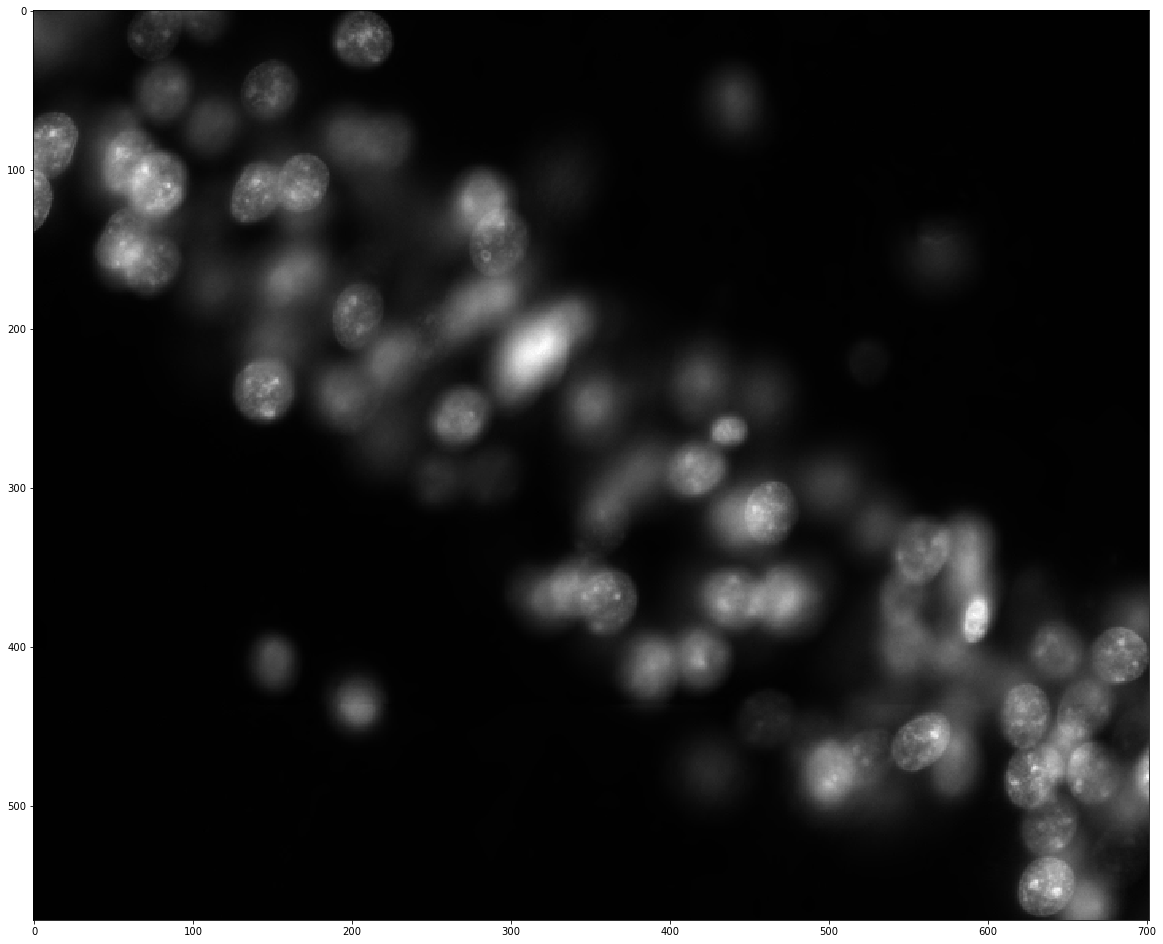

In [5]:
f, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(img[9, :, :], cmap='gray');

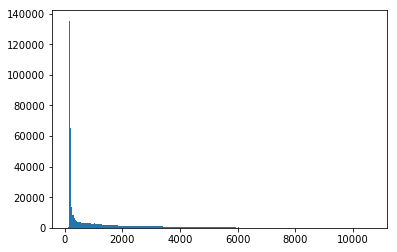

In [18]:
test_img = img[9, :, :]
plt.hist(test_img.ravel(), bins=256);

In [8]:
def gaussian_blur(image, sigma):
    # must convert image to float for this to work in a loop (unknown reason)
    image = (image*1.0)/255.0
    img_gaussian = np.empty_like(image)
    for i in range(len(image)):
        img_gaussian[i,:,:] = filters.gaussian(image[i,:,:], sigma)
    return img_gaussian

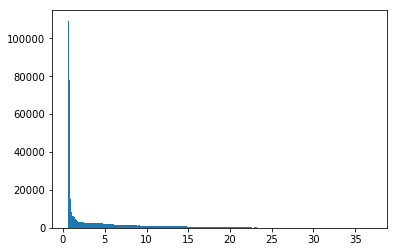

In [34]:
test_blur_stack = gaussian_blur(img, 5)
test_blur_single = test_blur[9, :, :]
plt.hist(test_blur_single.ravel(), bins=256);

56.707798697257417

# Comparing HEQ methods

## Local equalization

In [27]:
from skimage.filters import rank
from skimage.morphology import disk
rank.equalize(test_blur[9, :, :], selem=disk(5))

ValueError: Images of type float must be between -1 and 1.

## Contrast stretch

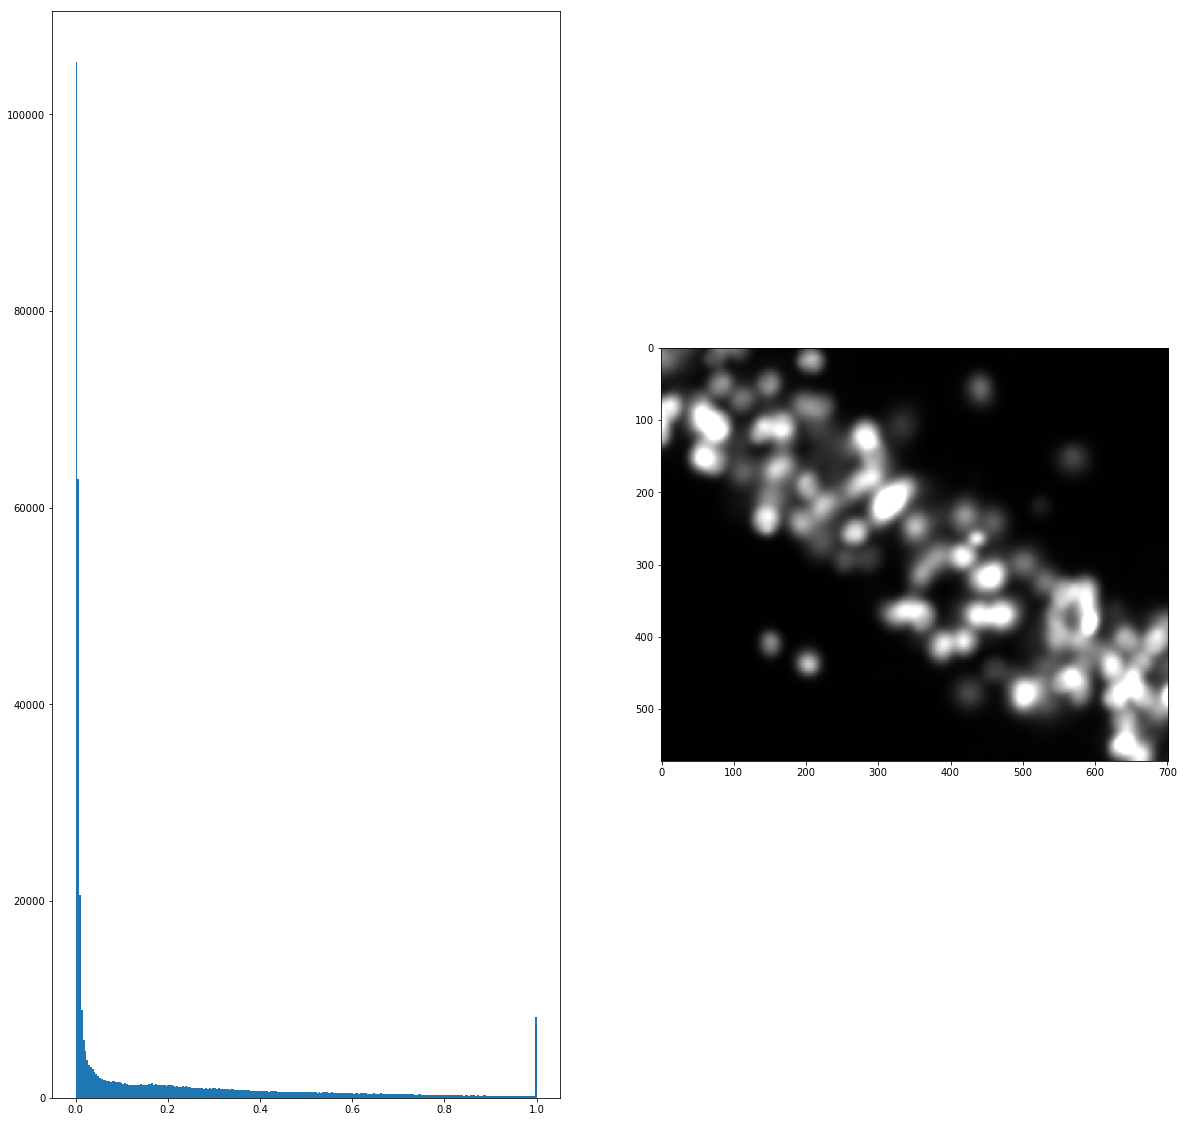

In [48]:
p2, p98 = np.percentile(test_blur_single, (2, 98))
img_rescale = exposure.rescale_intensity(test_blur_single, in_range=(p2, p98))

f, ax = plt.subplots(1,2, figsize=(20,20));
ax[0].hist(img_rescale.ravel(), bins=256)
ax[1].imshow(img_rescale, cmap='gray')

## Histogram equalization

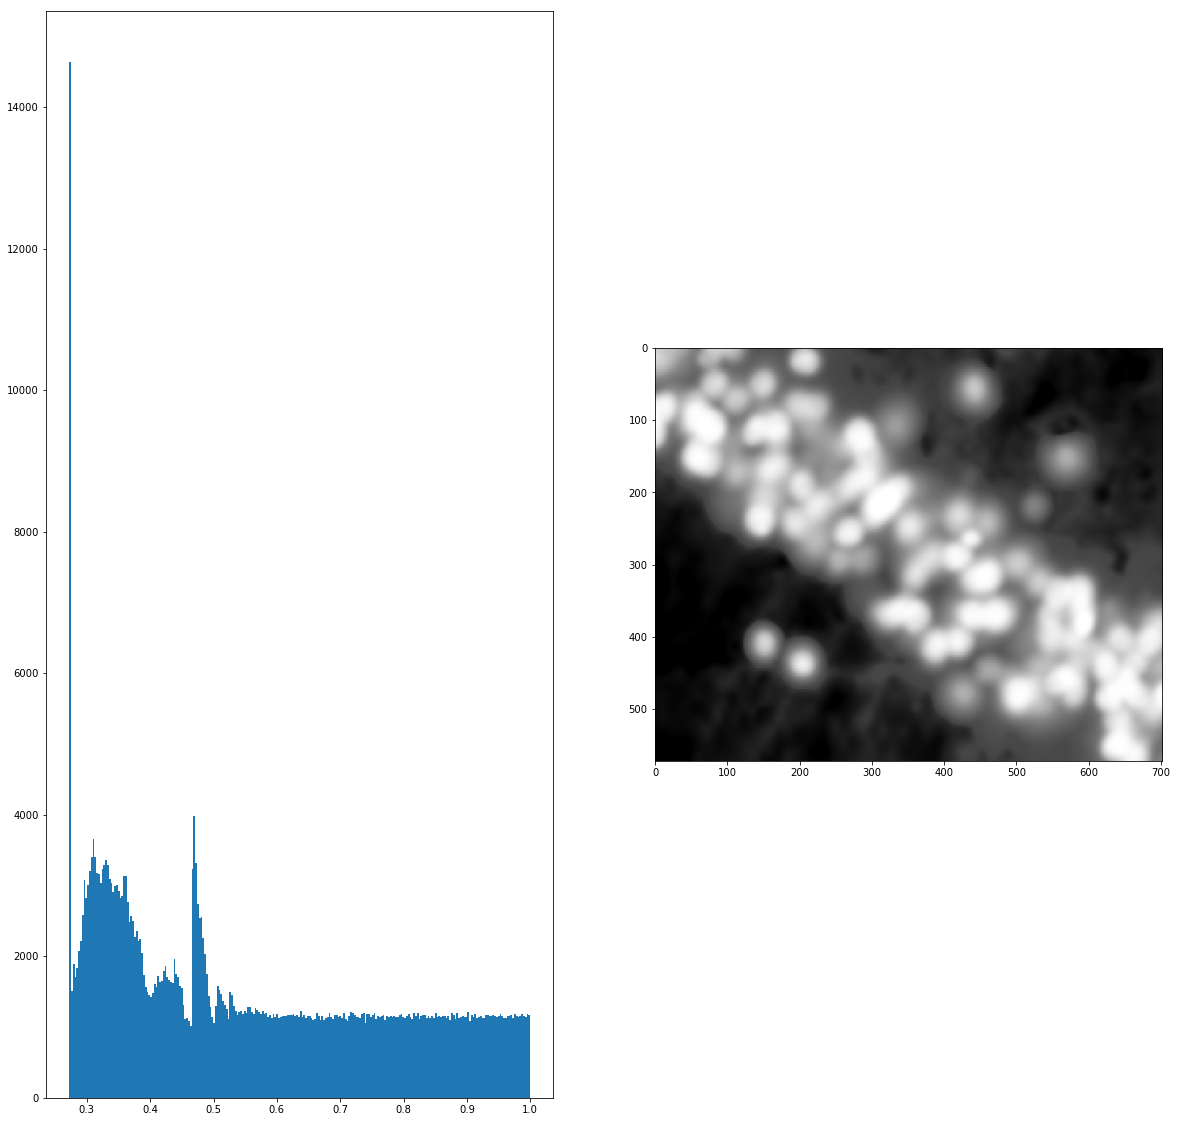

In [47]:
img_eq = exposure.equalize_hist(test_blur_single)

f, ax = plt.subplots(1,2, figsize=(20,20));
ax[0].hist(img_eq.ravel(), bins=256)
ax[1].imshow(img_eq, cmap='gray')

## Adaptive equalization

In [49]:
img_adapteq = exposure.equalize_adapthist(test_blur_single, clip_limit=0.03)

f, ax = plt.subplots(1,2, figsize=(20,20));
ax[0].hist(img_adapteq.ravel(), bins=256)
ax[1].imshow(img_adapteq, cmap='gray')

ValueError: Images of type float must be between -1 and 1.

## 